<a href="https://colab.research.google.com/github/alessandroz0512/portfolio-opt/blob/main/Portfolio-opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ------------------------
# SNIPPET 1: DOWNLOAD AND SAVE PRICE DATA
# ------------------------

import yfinance as yf
import pandas as pd

# ------------------------
# Step 1: Tickers & Market Index
# ------------------------
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "META",
    "JPM", "BAC", "WFC", "C", "GS",
    "JNJ", "PFE", "MRK", "ABBV", "LLY",
    "CAT", "BA", "GE", "HON", "UNP",
    "AMZN", "TSLA", "HD", "MCD", "NKE",
    "XOM", "CVX", "COP", "SLB", "EOG",
    "PG", "KO", "PEP", "WMT", "COST"
]
market_index = "^GSPC"
all_tickers = tickers + [market_index]

# ------------------------
# Step 2: Download Prices
# ------------------------
price_data = {}
for t in all_tickers:
    try:
        data = yf.download(t, start="2020-01-01", end="2025-01-01", progress=False, auto_adjust=True)
        if "Adj Close" in data.columns:
            adj = data["Adj Close"]
        else:
            adj = data.iloc[:,0]
        price_data[t] = adj
    except Exception as e:
        print(f"Could not download {t}: {e}")

# Convert dictionary to DataFrame
prices = pd.DataFrame(price_data).dropna(how="all")

# ------------------------
# Step 3: Save for reuse
# ------------------------
prices.to_pickle("sp500_prices.pkl")
print("Download complete and saved to sp500_prices.pkl")

Download complete and saved to sp500_prices.pkl


In [6]:
# ------------------------
# CONDITIONAL BETA DATASET FROM EXISTING DATA EXTRACTION
# ------------------------

import pandas as pd
import numpy as np

# ------------------------
# Step 1: Assuming you already have `prices` DataFrame from your code
prices = pd.DataFrame(price_data).dropna(how="all")
# ------------------------

# Calculate returns
returns = prices.pct_change().dropna()

# Market returns: S&P500
market_ret = returns["^GSPC"]

# ------------------------
# Step 2: Conditional Beta Function
# ------------------------
def conditional_beta(stock_ret, market_ret):
    up = market_ret > 0
    down = market_ret < 0
    if stock_ret[up].empty or stock_ret[down].empty:
        return np.nan, np.nan
    beta_plus = np.cov(stock_ret[up], market_ret[up])[0,1] / np.var(market_ret[up])
    beta_minus = np.cov(stock_ret[down], market_ret[down])[0,1] / np.var(market_ret[down])
    return beta_plus, beta_minus

# ------------------------
# Step 3: Compute Conditional Betas for All Tickers
# ------------------------
beta_data = []
for t in prices.columns:
    if t == "^GSPC":
        continue
    b_plus, b_minus = conditional_beta(returns[t], market_ret)
    beta_data.append({
        "Ticker": t,
        "Beta+": b_plus,
        "Beta-": b_minus,
        "Beta_Ratio": b_plus / b_minus if b_minus != 0 else np.nan
    })

beta_df = pd.DataFrame(beta_data)

# ------------------------
# Step 4: Save Dataset for Portfolio Optimization
# ------------------------
beta_df.to_csv("conditional_beta_dataset.csv", index=False)
print("Conditional beta dataset saved as conditional_beta_dataset.csv")

Conditional beta dataset saved as conditional_beta_dataset.csv


In [50]:
# -----------------------------
# LONG-ONLY CONDITIONAL BETA PORTFOLIO WORKFLOW
# -----------------------------
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import plotly.graph_objects as go

# -----------------------------
# PARAMETERS
# -----------------------------
tickers = [
    "AAPL","MSFT","NVDA","GOOGL","META",
    "JPM","BAC","WFC","C","GS",
    "JNJ","PFE","MRK","ABBV","LLY",
    "CAT","BA","GE","HON","UNP",
    "AMZN","TSLA","HD","MCD","NKE",
    "XOM","CVX","COP","SLB","EOG",
    "PG","KO","PEP","WMT","COST"
]
rf_rate = 0.02
down_weight = 1.5  # conditional beta adjustment
max_weight = 0.4  # max 40% per stock to increase diversification

# -----------------------------
# STEP 1: LOAD DATA
# -----------------------------
prices = pd.read_pickle("sp500_prices.pkl")
prices = prices[[t for t in tickers if t in prices.columns]]
returns = prices.pct_change().dropna()
expected_returns = returns.mean().values * 252
cov_matrix = returns.cov().values * 252  # annualized covariance

# Conditional beta dataset
beta_df = pd.read_csv("conditional_beta_dataset.csv")
beta_df = beta_df.set_index("Ticker").loc[prices.columns]
beta_plus = beta_df["Beta+"].values
beta_minus = beta_df["Beta-"].values

# -----------------------------
# STEP 2: ADJUST COVARIANCE MATRIX
# -----------------------------
adj = beta_plus**2 + down_weight * beta_minus**2
adjusted_cov = cov_matrix * np.outer(1 + adj, 1 + adj)

# -----------------------------
# STEP 3: PORTFOLIO FUNCTIONS
# -----------------------------
def portfolio_performance(weights, mu, cov, rf=rf_rate):
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = (ret - rf)/vol if vol != 0 else 0
    return ret, vol, sharpe

def neg_sharpe(weights, mu, cov, rf=rf_rate):
    # Standard negative Sharpe objective
    return -portfolio_performance(weights, mu, cov, rf)[2]

def optimize_portfolio(mu, cov, max_weight=max_weight):
    n = len(mu)
    init_guess = np.ones(n)/n
    bounds_list = [(0, max_weight)]*n  # long-only + max weight constraint
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # fully invested
    result = minimize(neg_sharpe, init_guess, args=(mu, cov),
                      method='SLSQP', bounds=bounds_list, constraints=constraints)
    return result.x

# -----------------------------
# STEP 4: RUN OPTIMIZATION
# -----------------------------
weights = optimize_portfolio(expected_returns, adjusted_cov)
ret, vol, sharpe = portfolio_performance(weights, expected_returns, adjusted_cov)

# -----------------------------
# STEP 5: OUTPUT TABLE FUNCTION
# -----------------------------
def make_weights_table(weights, name="Portfolio"):
    df = pd.DataFrame({
        "Ticker": prices.columns,
        f"{name} Weight": weights.round(4)
    })
    df["Expected Contribution"] = (weights * expected_returns).round(4)
    total_row = pd.DataFrame({
        "Ticker": ["Total"],
        f"{name} Weight": [df[f"{name} Weight"].sum().round(4)],
        "Expected Contribution": [df["Expected Contribution"].sum().round(4)]
    })
    df = pd.concat([df, total_row], ignore_index=True)
    return df

table = make_weights_table(weights, "Conditional Beta")
print("Conditional Beta Long-Only Portfolio:")
print(table)
print(f"Return: {ret:.3f}, Vol: {vol:.3f}, Sharpe: {sharpe:.3f}\n")

# -----------------------------
# STEP 6: COMPARE TO S&P500
# -----------------------------
try:
    market_prices = pd.read_pickle("sp500_prices.pkl")["^GSPC"]
    market_returns = market_prices.pct_change().dropna()
    market_mean = market_returns.mean() * 252
    market_vol = market_returns.std() * np.sqrt(252)
    market_sharpe = (market_mean - rf_rate) / market_vol
    print("S&P500 Performance:")
    print(f"Return: {market_mean:.3f}, Vol: {market_vol:.3f}, Sharpe: {market_sharpe:.3f}")
except KeyError:
    print("S&P500 prices not available in dataset.")

# -----------------------------
# STEP 7: PLOT PORTFOLIO ALLOCATION
# -----------------------------
def plot_portfolio_pie(weights, tickers, title="Portfolio Allocation"):
    fig = go.Figure(data=[go.Pie(
        labels=tickers,
        values=weights,
        hoverinfo='label+percent',
        textinfo='label+percent',
        textfont_size=18,
        hole=0.3
    )])
    fig.update_layout(
        title_text=title,
        title_font_size=24,
        height=800,
        width=800,
    )
    fig.show()

plot_portfolio_pie(weights, prices.columns, "Conditional Beta Long-Only Allocation")

# -----------------------------
# STEP 8: PLOT STOCK PRICE HISTORY
# -----------------------------
def plot_stock_prices(prices, tickers, title="Stock Prices Over Time"):
    fig = go.Figure()
    for t in tickers:
        fig.add_trace(go.Scatter(
            x=prices.index,
            y=prices[t],
            mode='lines',
            name=t
        ))
    fig.update_layout(
        title=title,
        title_font_size=24,
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        height=800,
        width=1200
    )
    fig.show()

plot_stock_prices(prices, prices.columns, "Stock Prices Over Time")

Conditional Beta Long-Only Portfolio:
   Ticker  Conditional Beta Weight  Expected Contribution
0    AAPL                   0.0000                 0.0000
1    MSFT                   0.0000                 0.0000
2    NVDA                   0.0000                 0.0000
3   GOOGL                   0.0000                 0.0000
4    META                   0.0000                 0.0000
5     JPM                   0.0000                 0.0000
6     BAC                   0.0000                 0.0000
7     WFC                   0.0000                 0.0000
8       C                   0.0000                 0.0000
9      GS                   0.0000                 0.0000
10    JNJ                   0.0000                 0.0000
11    PFE                   0.0000                 0.0000
12    MRK                   0.0000                 0.0000
13   ABBV                   0.1168                 0.0247
14    LLY                   0.3072                 0.1287
15    CAT                   0.0009

Optimal down-beta weight: 0.10
Conditional Beta Portfolio Sharpe: 1.639
Conditional Beta Portfolio:
   Ticker  Conditional Beta Weight  Expected Contribution
0    AAPL                   0.0843                 0.0251
1    MSFT                  -0.0810                -0.0202
2    NVDA                   0.0562                 0.0432
3   GOOGL                   0.0583                 0.0150
4    META                   0.0209                 0.0064
5     JPM                   0.2169                 0.0408
6     BAC                  -0.0908                -0.0119
7     WFC                   0.0091                 0.0014
8       C                  -0.2174                -0.0188
9      GS                   0.1965                 0.0508
10    JNJ                  -0.3000                -0.0136
11    PFE                  -0.2414                -0.0032
12    MRK                  -0.2543                -0.0212
13   ABBV                   0.3000                 0.0634
14    LLY                   0.

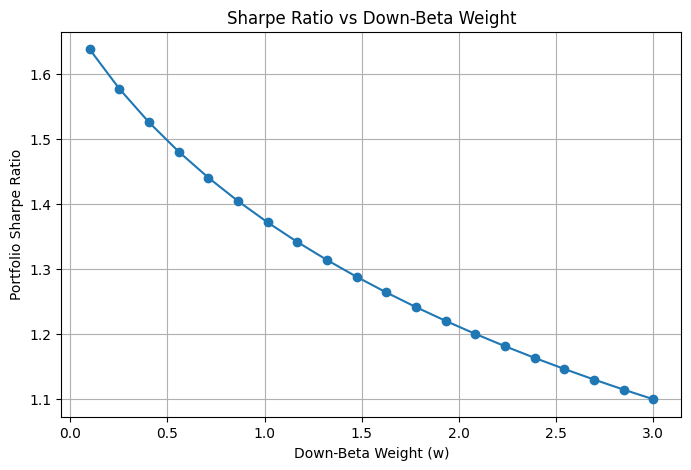

In [30]:
# -----------------------------
# HIGH LEVERAGE CONDITIONAL BETA DOLLAR-NEUTRAL PORTFOLIO OPTIMIZATION
# -----------------------------
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
tickers = [
    "AAPL","MSFT","NVDA","GOOGL","META",
    "JPM","BAC","WFC","C","GS",
    "JNJ","PFE","MRK","ABBV","LLY",
    "CAT","BA","GE","HON","UNP",
    "AMZN","TSLA","HD","MCD","NKE",
    "XOM","CVX","COP","SLB","EOG",
    "PG","KO","PEP","WMT","COST"
]
rf_rate = 0.02
weight_bound = 0.3  # max long/short per asset
allow_short = True

# -----------------------------
# STEP 1: LOAD DATA
# -----------------------------
prices = pd.read_pickle("sp500_prices.pkl")
prices = prices[[t for t in tickers if t in prices.columns]]
returns = prices.pct_change().dropna()
expected_returns = returns.mean().values * 252
cov_matrix = returns.cov().values * 252

# Load conditional beta dataset
beta_df = pd.read_csv("conditional_beta_dataset.csv")
beta_df = beta_df.set_index("Ticker").loc[prices.columns]
beta_plus = beta_df["Beta+"].values
beta_minus = beta_df["Beta-"].values

# -----------------------------
# STEP 2: PORTFOLIO FUNCTIONS
# -----------------------------
def portfolio_performance(weights, mu, cov, rf=rf_rate):
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = (ret - rf)/vol if vol != 0 else 0
    return ret, vol, sharpe

def neg_sharpe(weights, mu, cov, rf=rf_rate):
    return -portfolio_performance(weights, mu, cov, rf)[2]

def optimize_portfolio(mu, cov, bounds, allow_short=True, dollar_neutral=True):
    n = len(mu)
    # Start with equal long/short allocation
    init_guess = np.zeros(n)
    half = n//2
    init_guess[:half] = weight_bound/2
    init_guess[half:] = -weight_bound/2

    bounds_list = [(-bounds,bounds)]*n if allow_short else [(0,bounds)]*n
    constraints = []
    if dollar_neutral:
        constraints = [{'type':'eq', 'fun': lambda w: np.sum(w)}]

    result = minimize(neg_sharpe, init_guess, args=(mu,cov),
                      method='SLSQP', bounds=bounds_list, constraints=constraints)
    return result.x

# -----------------------------
# STEP 3: GRID SEARCH OVER DOWN-BETA WEIGHT
# -----------------------------
w_values = np.linspace(0.1, 3, 20)
sharpe_list = []

best_sharpe = -np.inf
best_w = None
best_weights = None

for w in w_values:
    adjusted_cov = cov_matrix * (1 + beta_plus**2 + w*beta_minus**2)[:, None]
    adjusted_cov = (adjusted_cov + adjusted_cov.T)/2
    weights = optimize_portfolio(expected_returns, adjusted_cov, weight_bound,
                                 allow_short=True, dollar_neutral=True)
    _, _, sharpe = portfolio_performance(weights, expected_returns, adjusted_cov)
    sharpe_list.append(sharpe)
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_w = w
        best_weights = weights

print(f"Optimal down-beta weight: {best_w:.2f}")
print(f"Conditional Beta Portfolio Sharpe: {best_sharpe:.3f}")

# -----------------------------
# STEP 4: STANDARD BETA PORTFOLIO
# -----------------------------
weights_beta = optimize_portfolio(expected_returns, cov_matrix, weight_bound,
                                  allow_short=True, dollar_neutral=True)
ret_b, vol_b, sharpe_b = portfolio_performance(weights_beta, expected_returns, cov_matrix)

# -----------------------------
# STEP 5: TABLE FUNCTION
# -----------------------------
def make_weights_table(weights, name):
    df = pd.DataFrame({
        "Ticker": prices.columns,
        f"{name} Weight": weights.round(4)
    })
    df["Expected Contribution"] = (weights * expected_returns).round(4)
    total_row = pd.DataFrame({
        "Ticker": ["Total"],
        f"{name} Weight": [df[f"{name} Weight"].sum().round(4)],
        "Expected Contribution": [df["Expected Contribution"].sum().round(4)]
    })
    df = pd.concat([df, total_row], ignore_index=True)
    return df

table_conditional = make_weights_table(best_weights, "Conditional Beta")
table_beta = make_weights_table(weights_beta, "Standard Beta")

print("Conditional Beta Portfolio:")
print(table_conditional)
ret_c, vol_c, sharpe_c = portfolio_performance(best_weights, expected_returns, cov_matrix)
print(f"Return: {ret_c:.3f}, Vol: {vol_c:.3f}, Sharpe: {sharpe_c:.3f}\n")

print("Standard Beta Portfolio:")
print(table_beta)
print(f"Return: {ret_b:.3f}, Vol: {vol_b:.3f}, Sharpe: {sharpe_b:.3f}\n")

def make_weights_table(weights, name):
    df = pd.DataFrame({
        "Ticker": prices.columns,
        f"{name} Weight": weights.round(4)
    })
    df["Expected Contribution"] = (weights * expected_returns).round(4)

    # Compute long and short sums
    sum_long = df[f"{name} Weight"][df[f"{name} Weight"] > 0].sum().round(4)
    sum_short = df[f"{name} Weight"][df[f"{name} Weight"] < 0].sum().round(4)

    total_row = pd.DataFrame({
        "Ticker": ["Total"],
        f"{name} Weight": [df[f"{name} Weight"].sum().round(4)],
        "Expected Contribution": [df["Expected Contribution"].sum().round(4)]
    })

    summary_row = pd.DataFrame({
        "Ticker": ["Long/Short Sum"],
        f"{name} Weight": [f"Long: {sum_long}, Short: {sum_short}"],
        "Expected Contribution": [""]
    })

    df = pd.concat([df, total_row, summary_row], ignore_index=True)
    return df

table_conditional = make_weights_table(best_weights, "Conditional Beta")
table_beta = make_weights_table(weights_beta, "Standard Beta")

print("Conditional Beta Portfolio:")
print(table_conditional)
print("\nStandard Beta Portfolio:")
print(table_beta)

# -----------------------------
# STEP 6: COMPARE TO S&P500
# -----------------------------
market_prices = pd.read_pickle("sp500_prices.pkl")["^GSPC"]
market_returns = market_prices.pct_change().dropna()
market_mean = market_returns.mean() * 252
market_vol = market_returns.std() * np.sqrt(252)
market_sharpe = (market_mean - rf_rate) / market_vol

print(f"S&P500 Return: {market_mean:.3f}, Vol: {market_vol:.3f}, Sharpe: {market_sharpe:.3f}")
print(f"Conditional Beta Sharpe vs S&P500: {sharpe_c:.3f} | {market_sharpe:.3f}")
print(f"Standard Beta Sharpe vs S&P500: {sharpe_b:.3f} | {market_sharpe:.3f}")

# -----------------------------
# STEP 7: SHARPE VS DOWN-BETA WEIGHT PLOT
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(w_values, sharpe_list, marker='o')
plt.xlabel("Down-Beta Weight (w)")
plt.ylabel("Portfolio Sharpe Ratio")
plt.title("Sharpe Ratio vs Down-Beta Weight")
plt.grid(True)
plt.show()

In [42]:
# -----------------------------
# LONG/SHORT DOLLAR-NEUTRAL CONDITIONAL BETA PORTFOLIO
# -----------------------------
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import plotly.graph_objects as go
import plotly.express as px

# -----------------------------
# PARAMETERS
# -----------------------------
tickers = [
    "AAPL","MSFT","NVDA","GOOGL","META",
    "JPM","BAC","WFC","C","GS",
    "JNJ","PFE","MRK","ABBV","LLY",
    "CAT","BA","GE","HON","UNP",
    "AMZN","TSLA","HD","MCD","NKE",
    "XOM","CVX","COP","SLB","EOG",
    "PG","KO","PEP","WMT","COST"
]
rf_rate = 0.02
weight_bound = 0.3
allow_short = True
dollar_neutral = True

# -----------------------------
# STEP 1: LOAD DATA
# -----------------------------
prices = pd.read_pickle("sp500_prices.pkl")
prices = prices[[t for t in tickers if t in prices.columns]]
returns = prices.pct_change().dropna()
expected_returns = returns.mean().values * 252
cov_matrix = returns.cov().values * 252

beta_df = pd.read_csv("conditional_beta_dataset.csv")
beta_df = beta_df.set_index("Ticker").loc[prices.columns]
beta_plus = beta_df["Beta+"].values
beta_minus = beta_df["Beta-"].values

# -----------------------------
# STEP 2: PORTFOLIO FUNCTIONS
# -----------------------------
def portfolio_performance(weights, mu, cov, rf=rf_rate):
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = (ret - rf)/vol if vol != 0 else 0
    return ret, vol, sharpe

def neg_sharpe(weights, mu, cov, rf=rf_rate):
    return -portfolio_performance(weights, mu, cov, rf)[2]

def optimize_portfolio(mu, cov, bounds, allow_short=True, dollar_neutral=True, init_guess=None):
    n = len(mu)
    if init_guess is None:
        init_guess = np.zeros(n)
        half = n // 2
        init_guess[:half] = bounds/2
        init_guess[half:] = -bounds/2

    bounds_list = [(-bounds,bounds)]*n if allow_short else [(0,bounds)]*n
    constraints = []
    if dollar_neutral:
        constraints = [{'type':'eq', 'fun': lambda w: np.sum(w)}]

    result = minimize(neg_sharpe, init_guess, args=(mu,cov),
                      method='SLSQP', bounds=bounds_list, constraints=constraints)
    w_opt = result.x
    long_sum = w_opt[w_opt>0].sum()
    short_sum = -w_opt[w_opt<0].sum()
    if max(long_sum, short_sum) > 1:
        w_opt /= max(long_sum, short_sum)
    return w_opt

# -----------------------------
# STEP 3: GRID SEARCH OVER DOWN-BETA WEIGHT
# -----------------------------
w_values = np.linspace(0, 1.5, 15)
sharpe_list = []
best_sharpe = -np.inf
best_w = None
best_weights = None
best_cov = None

for w in w_values:
    adjusted_cov = cov_matrix * (1 + beta_plus**2 + w*beta_minus**2)[:, None]
    adjusted_cov = (adjusted_cov + adjusted_cov.T)/2
    weights = optimize_portfolio(expected_returns, adjusted_cov, weight_bound,
                                 allow_short=True, dollar_neutral=True)
    _, _, sharpe = portfolio_performance(weights, expected_returns, adjusted_cov)
    sharpe_list.append(sharpe)
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_w = w
        best_weights = weights
        best_cov = adjusted_cov

print(f"Optimal down-beta weight: {best_w:.2f}")
print(f"Conditional Beta Portfolio Sharpe: {best_sharpe:.3f}")

# -----------------------------
# STEP 4: STANDARD BETA PORTFOLIO
# -----------------------------
weights_beta = optimize_portfolio(expected_returns, cov_matrix, weight_bound,
                                  allow_short=True, dollar_neutral=True)
ret_b, vol_b, sharpe_b = portfolio_performance(weights_beta, expected_returns, cov_matrix)

# -----------------------------
# STEP 5: TABLE FUNCTION WITH LONG/SHORT SUMS
# -----------------------------
def make_weights_table(weights, name):
    df = pd.DataFrame({
        "Ticker": prices.columns,
        f"{name} Weight": weights.round(4)
    })
    df["Expected Contribution"] = (weights * expected_returns).round(4)
    sum_long = df[f"{name} Weight"][df[f"{name} Weight"]>0].sum().round(4)
    sum_short = df[f"{name} Weight"][df[f"{name} Weight"]<0].sum().round(4)

    total_row = pd.DataFrame({
        "Ticker":["Total"],
        f"{name} Weight":[df[f"{name} Weight"].sum().round(4)],
        "Expected Contribution":[df["Expected Contribution"].sum().round(4)]
    })
    summary_row = pd.DataFrame({
        "Ticker":["Long/Short Sum"],
        f"{name} Weight":[f"Long: {sum_long}, Short: {sum_short}"],
        "Expected Contribution":[""]
    })
    df = pd.concat([df, total_row, summary_row], ignore_index=True)
    return df

table_conditional = make_weights_table(best_weights, "Conditional Beta")
table_beta = make_weights_table(weights_beta, "Standard Beta")

print("\nConditional Beta Portfolio:")
print(table_conditional)
ret_c, vol_c, sharpe_c = portfolio_performance(best_weights, expected_returns, best_cov)
print(f"Return: {ret_c:.3f}, Vol: {vol_c:.3f}, Sharpe: {sharpe_c:.3f}\n")

print("Standard Beta Portfolio:")
print(table_beta)
print(f"Return: {ret_b:.3f}, Vol: {vol_b:.3f}, Sharpe: {sharpe_b:.3f}\n")

# -----------------------------
# STEP 6: COMPARE TO S&P500
# -----------------------------
market_prices = pd.read_pickle("sp500_prices.pkl")["^GSPC"]
market_returns = market_prices.pct_change().dropna()
market_mean = market_returns.mean() * 252
market_vol = market_returns.std() * np.sqrt(252)
market_sharpe = (market_mean - rf_rate)/market_vol

print(f"S&P500 Return: {market_mean:.3f}, Vol: {market_vol:.3f}, Sharpe: {market_sharpe:.3f}")
print(f"Conditional Beta Sharpe vs S&P500: {sharpe_c:.3f} | {market_sharpe:.3f}")
print(f"Standard Beta Sharpe vs S&P500: {sharpe_b:.3f} | {market_sharpe:.3f}")



# -----------------------------
# STEP 7: LONG/SHORT PIE CHARTS (Plotly)
# -----------------------------
from plotly.subplots import make_subplots

long_weights = np.array([w if w>0 else 0 for w in best_weights])
short_weights = np.array([-w if w<0 else 0 for w in best_weights])

long_labels = np.array(prices.columns)[long_weights>0]
long_values = long_weights[long_weights>0]

short_labels = np.array(prices.columns)[short_weights>0]
short_values = short_weights[short_weights>0]

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Long Positions', 'Short Positions'])

fig.add_trace(go.Pie(labels=long_labels, values=long_values, name='Long Positions',
                     hole=0.3, marker=dict(colors=px.colors.sequential.Greens)), row=1, col=1)

fig.add_trace(go.Pie(labels=short_labels, values=short_values, name='Short Positions',
                     hole=0.3, marker=dict(colors=px.colors.sequential.Reds)), row=1, col=2)

fig.update_layout(title_text="Long/Short Portfolio Allocation")
fig.show()

# -----------------------------
# STEP 8: TIME SERIES OF STOCKS (Plotly)
# -----------------------------
# Color code: green for long, red for short
colors = ["green" if w>0 else "red" for w in best_weights]

fig = go.Figure()
for i, t in enumerate(prices.columns):
    fig.add_trace(go.Scatter(x=prices.index, y=prices[t], mode='lines', name=t, line=dict(color=colors[i])))

fig.update_layout(title="Stock Prices During Period",
                  xaxis_title="Date", yaxis_title="Price")
fig.show()

Optimal down-beta weight: 0.00
Conditional Beta Portfolio Sharpe: 1.584

Conditional Beta Portfolio:
            Ticker       Conditional Beta Weight Expected Contribution
0             AAPL                        0.0347                0.0103
1             MSFT                       -0.0363                -0.009
2             NVDA                        0.0249                0.0192
3            GOOGL                        0.0254                0.0065
4             META                        0.0092                0.0028
5              JPM                        0.0936                0.0176
6              BAC                       -0.0399               -0.0052
7              WFC                        0.0041                0.0006
8                C                       -0.0949               -0.0082
9               GS                        0.0847                0.0219
10             JNJ                       -0.1264               -0.0057
11             PFE                       -0.101